In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Load the PROCESSED dataset (not the raw one)
try:
    df = pd.read_csv('accepted_2007_to_2018Q4.csv', low_memory=False)
    print("Loaded from CSV")
except:
    df = pd.read_pickle('../data/processed/loans_with_target.pkl')
    print("Loaded from pickle")

print(f"Dataset loaded: {len(df):,} rows x {df.shape[1]} columns")
print(f"Default rate: {df['is_default'].mean()*100:.2f}%")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Verify target variable exists
if 'is_default' not in df.columns:
    print("ERROR: is_default column not found. Please re-run Phase 1.")
else:
    print("Target variable 'is_default' confirmed present")

Loaded from CSV
Dataset loaded: 1,348,099 rows x 154 columns
Default rate: 19.98%
Memory usage: 3542.98 MB
Target variable 'is_default' confirmed present


In [12]:
# Calculate missing percentages
missing_pct = (df.isnull().sum() / len(df) * 100).sort_values(ascending=False)
missing_df = pd.DataFrame({
    'column': missing_pct.index,
    'missing_pct': missing_pct.values
})

# Filter to columns with >0% missing
missing_df = missing_df[missing_df['missing_pct'] > 0]

print("MISSING DATA ANALYSIS")
print("="*60)
print(f"Columns with missing data: {len(missing_df)} out of {df.shape[1]}")
print("\nTop 20 columns with missing values:")
print(missing_df.head(20))

# Identify columns to potentially drop (>50% missing)
high_missing = missing_df[missing_df['missing_pct'] > 50]['column'].tolist()
print(f"\nColumns with >50% missing (consider dropping): {len(high_missing)}")

MISSING DATA ANALYSIS
Columns with missing data: 113 out of 154

Top 20 columns with missing values:
                                        column  missing_pct
0                                    member_id   100.000000
1                                 next_pymnt_d    99.793116
2   orig_projected_additional_accrued_interest    99.721015
3                            hardship_end_date    99.573028
4               hardship_payoff_balance_amount    99.573028
5                 hardship_last_payment_amount    99.573028
6                          hardship_start_date    99.573028
7                                 hardship_dpd    99.573028
8                                hardship_type    99.573028
9                              hardship_reason    99.573028
10                        hardship_loan_status    99.573028
11                             hardship_length    99.573028
12                             hardship_status    99.573028
13                               deferral_term    99.573028

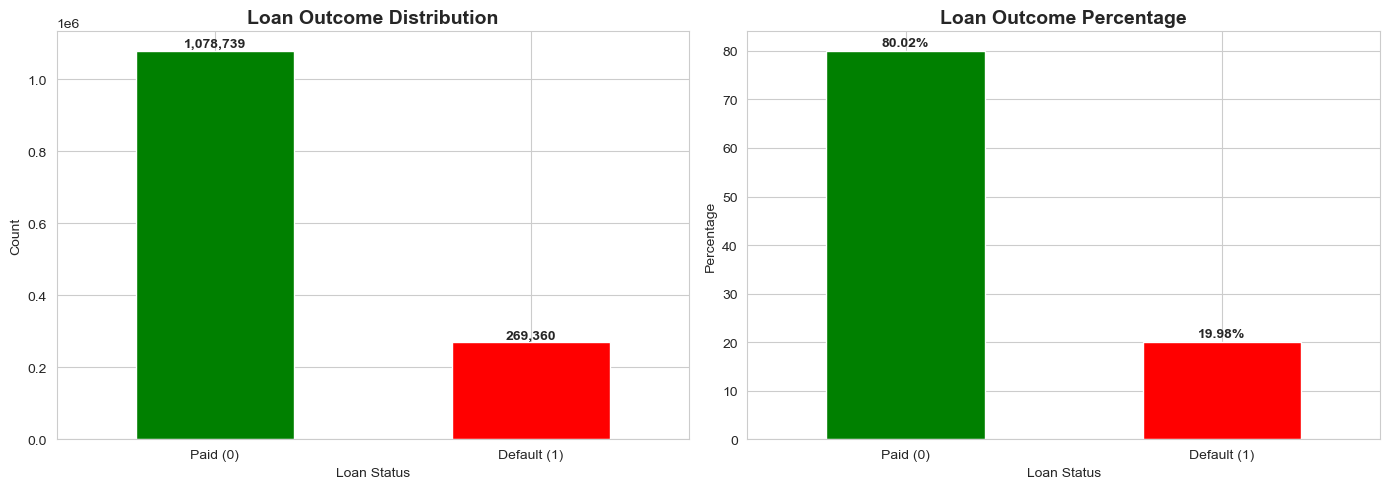

Class imbalance ratio: 4.00:1
Note: This imbalance will require balancing techniques during modeling


In [14]:
# Visualize class imbalance
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
df['is_default'].value_counts().plot(kind='bar', ax=axes[0], color=['green', 'red'])
axes[0].set_title('Loan Outcome Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Loan Status')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(['Paid (0)', 'Default (1)'], rotation=0)
for i, v in enumerate(df['is_default'].value_counts().values):
    axes[0].text(i, v + 10000, f'{v:,}', ha='center', fontweight='bold')

# Percentage plot
default_pct = df['is_default'].value_counts(normalize=True) * 100
default_pct.plot(kind='bar', ax=axes[1], color=['green', 'red'])
axes[1].set_title('Loan Outcome Percentage', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Loan Status')
axes[1].set_ylabel('Percentage')
axes[1].set_xticklabels(['Paid (0)', 'Default (1)'], rotation=0)
for i, v in enumerate(default_pct.values):
    axes[1].text(i, v + 1, f'{v:.2f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('../reports/target_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Class imbalance ratio: {(1-df['is_default'].mean()) / df['is_default'].mean():.2f}:1")
print("Note: This imbalance will require balancing techniques during modeling")

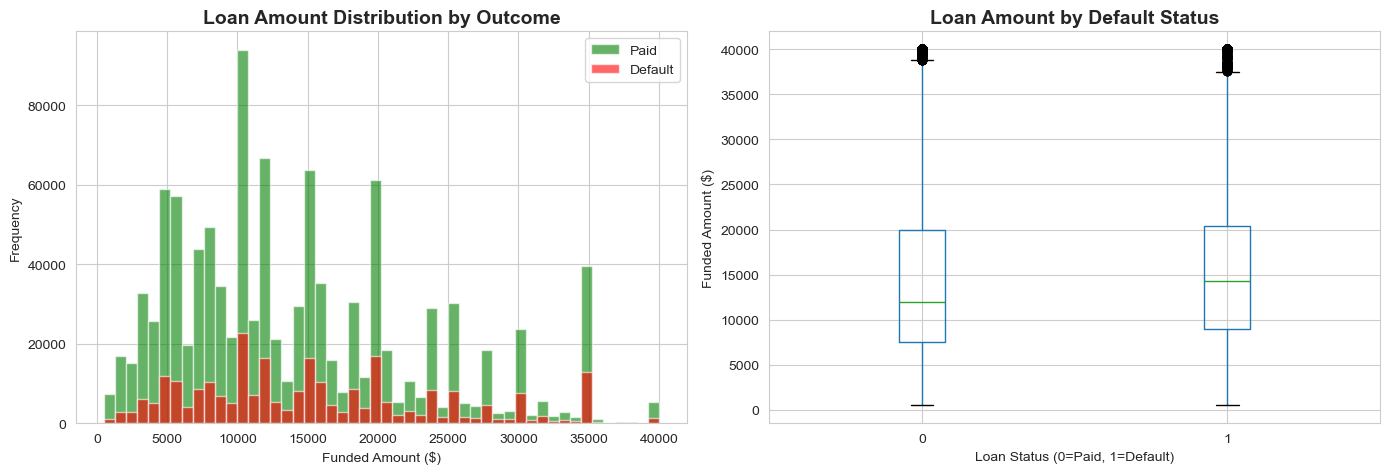

LOAN AMOUNT STATISTICS BY DEFAULT STATUS

Non-Defaulters:
count    1.078739e+06
mean     1.411581e+04
std      8.664015e+03
min      5.000000e+02
25%      7.500000e+03
50%      1.200000e+04
75%      2.000000e+04
max      4.000000e+04
Name: funded_amnt, dtype: float64

Defaulters:
count    269360.000000
mean      15539.056560
std        8811.315479
min         500.000000
25%        9000.000000
50%       14250.000000
75%       20400.000000
max       40000.000000
Name: funded_amnt, dtype: float64

Average loan for paid loans: $14,115.81
Average loan for defaults: $15,539.06
Difference: $1,423.24 (10.08% higher)


In [16]:
# Compare loan amounts between defaulters and non-defaulters
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribution comparison
df[df['is_default']==0]['funded_amnt'].hist(bins=50, alpha=0.6, label='Paid', ax=axes[0], color='green')
df[df['is_default']==1]['funded_amnt'].hist(bins=50, alpha=0.6, label='Default', ax=axes[0], color='red')
axes[0].set_title('Loan Amount Distribution by Outcome', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Funded Amount ($)')
axes[0].set_ylabel('Frequency')
axes[0].legend()

# Box plot comparison
df.boxplot(column='funded_amnt', by='is_default', ax=axes[1])
axes[1].set_title('Loan Amount by Default Status', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Loan Status (0=Paid, 1=Default)')
axes[1].set_ylabel('Funded Amount ($)')
plt.suptitle('')

plt.tight_layout()
plt.savefig('../reports/loan_amount_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Summary statistics
print("LOAN AMOUNT STATISTICS BY DEFAULT STATUS")
print("="*60)
print("\nNon-Defaulters:")
print(df[df['is_default']==0]['funded_amnt'].describe())
print("\nDefaulters:")
print(df[df['is_default']==1]['funded_amnt'].describe())

avg_paid = df[df['is_default']==0]['funded_amnt'].mean()
avg_default = df[df['is_default']==1]['funded_amnt'].mean()
print(f"\nAverage loan for paid loans: ${avg_paid:,.2f}")
print(f"Average loan for defaults: ${avg_default:,.2f}")
print(f"Difference: ${avg_default - avg_paid:,.2f} ({((avg_default/avg_paid - 1)*100):.2f}% higher)")

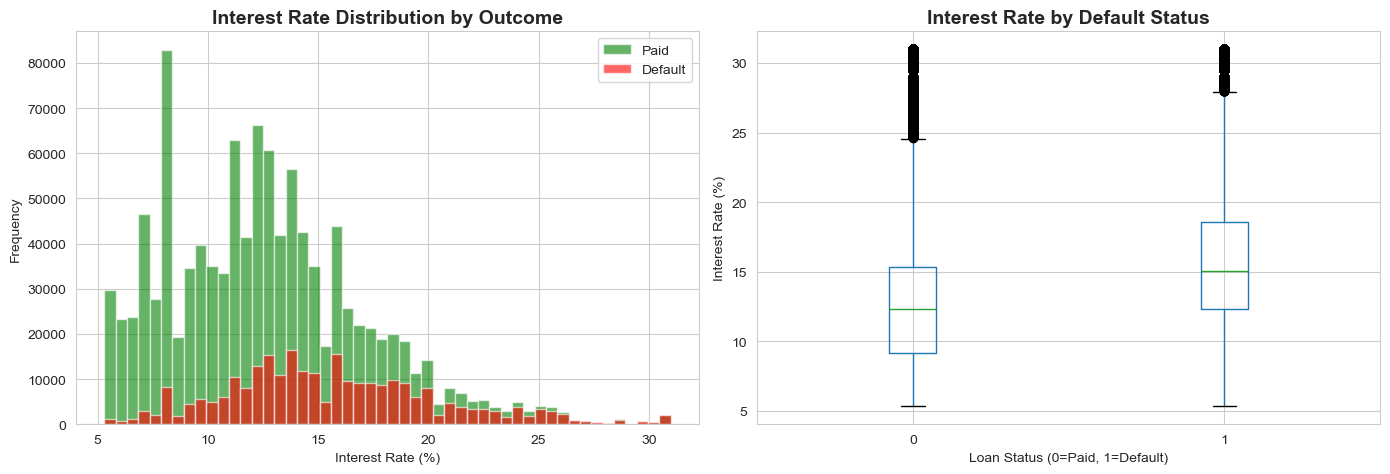

INTEREST RATE STATISTICS BY DEFAULT STATUS

Non-Defaulters:
count    1.078739e+06
mean     1.262579e+01
std      4.524947e+00
min      5.310000e+00
25%      9.170000e+00
50%      1.229000e+01
75%      1.531000e+01
max      3.099000e+01
Name: int_rate, dtype: float64

Defaulters:
count    269360.000000
mean         15.707638
std           4.906016
min           5.310000
25%          12.290000
50%          15.050000
75%          18.550000
max          30.990000
Name: int_rate, dtype: float64

Insight: Higher interest rates correlate with higher default risk
This confirms the lender's existing risk assessment is directionally correct


In [18]:
# Interest rate is a key pricing mechanism for risk
df['int_rate'] = pd.to_numeric(df['int_rate'], errors='coerce')

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribution by default status
df[df['is_default']==0]['int_rate'].hist(bins=50, alpha=0.6, label='Paid', ax=axes[0], color='green')
df[df['is_default']==1]['int_rate'].hist(bins=50, alpha=0.6, label='Default', ax=axes[0], color='red')
axes[0].set_title('Interest Rate Distribution by Outcome', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Interest Rate (%)')
axes[0].set_ylabel('Frequency')
axes[0].legend()

# Box plot
df.boxplot(column='int_rate', by='is_default', ax=axes[1])
axes[1].set_title('Interest Rate by Default Status', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Loan Status (0=Paid, 1=Default)')
axes[1].set_ylabel('Interest Rate (%)')
plt.suptitle('')

plt.tight_layout()
plt.savefig('../reports/interest_rate_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("INTEREST RATE STATISTICS BY DEFAULT STATUS")
print("="*60)
print("\nNon-Defaulters:")
print(df[df['is_default']==0]['int_rate'].describe())
print("\nDefaulters:")
print(df[df['is_default']==1]['int_rate'].describe())

print("\nInsight: Higher interest rates correlate with higher default risk")
print("This confirms the lender's existing risk assessment is directionally correct")

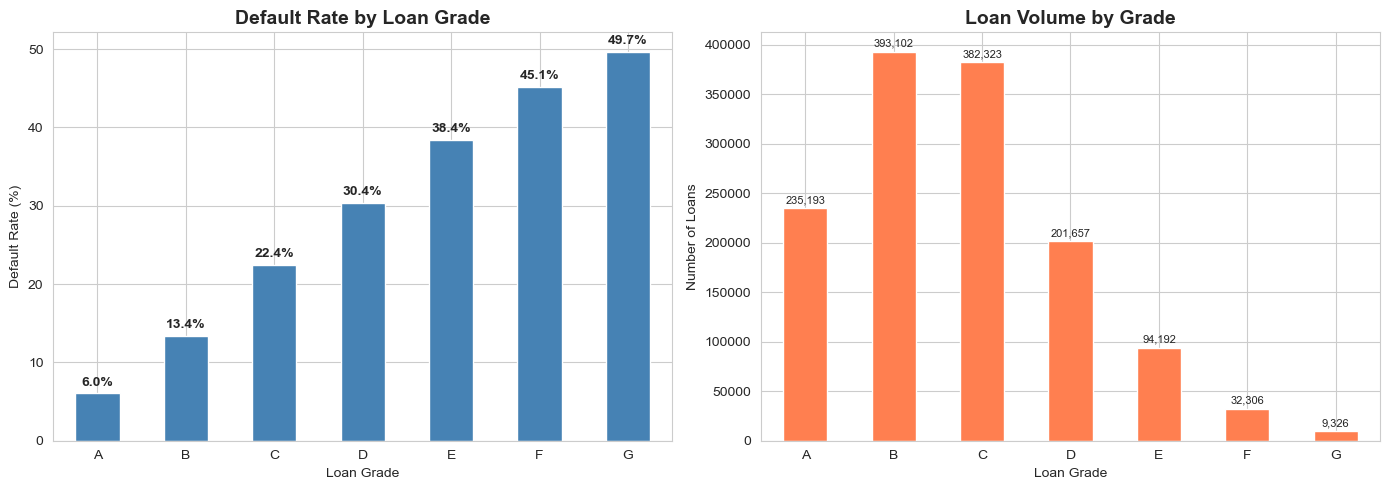

DEFAULT RATE BY LOAN GRADE
       default_rate  loan_count
grade                          
A          6.043547      235193
B         13.396269      393102
C         22.443065      382323
D         30.380299      201657
E         38.431077       94192
F         45.146412       32306
G         49.667596        9326

Key Finding: Clear risk gradient from A to G grades
Grade will be a strong predictor in our model


In [20]:
# Grade is the lender's internal risk classification
grade_default_rate = df.groupby('grade')['is_default'].agg(['mean', 'count'])
grade_default_rate.columns = ['default_rate', 'loan_count']
grade_default_rate['default_rate'] = grade_default_rate['default_rate'] * 100
grade_default_rate = grade_default_rate.sort_index()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Default rate by grade
grade_default_rate['default_rate'].plot(kind='bar', ax=axes[0], color='steelblue')
axes[0].set_title('Default Rate by Loan Grade', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Loan Grade')
axes[0].set_ylabel('Default Rate (%)')
axes[0].set_xticklabels(grade_default_rate.index, rotation=0)
for i, v in enumerate(grade_default_rate['default_rate'].values):
    axes[0].text(i, v + 1, f'{v:.1f}%', ha='center', fontweight='bold')

# Loan volume by grade
grade_default_rate['loan_count'].plot(kind='bar', ax=axes[1], color='coral')
axes[1].set_title('Loan Volume by Grade', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Loan Grade')
axes[1].set_ylabel('Number of Loans')
axes[1].set_xticklabels(grade_default_rate.index, rotation=0)
for i, v in enumerate(grade_default_rate['loan_count'].values):
    axes[1].text(i, v + 5000, f'{v:,}', ha='center', fontsize=8)

plt.tight_layout()
plt.savefig('../reports/grade_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("DEFAULT RATE BY LOAN GRADE")
print("="*60)
print(grade_default_rate)
print("\nKey Finding: Clear risk gradient from A to G grades")
print("Grade will be a strong predictor in our model")

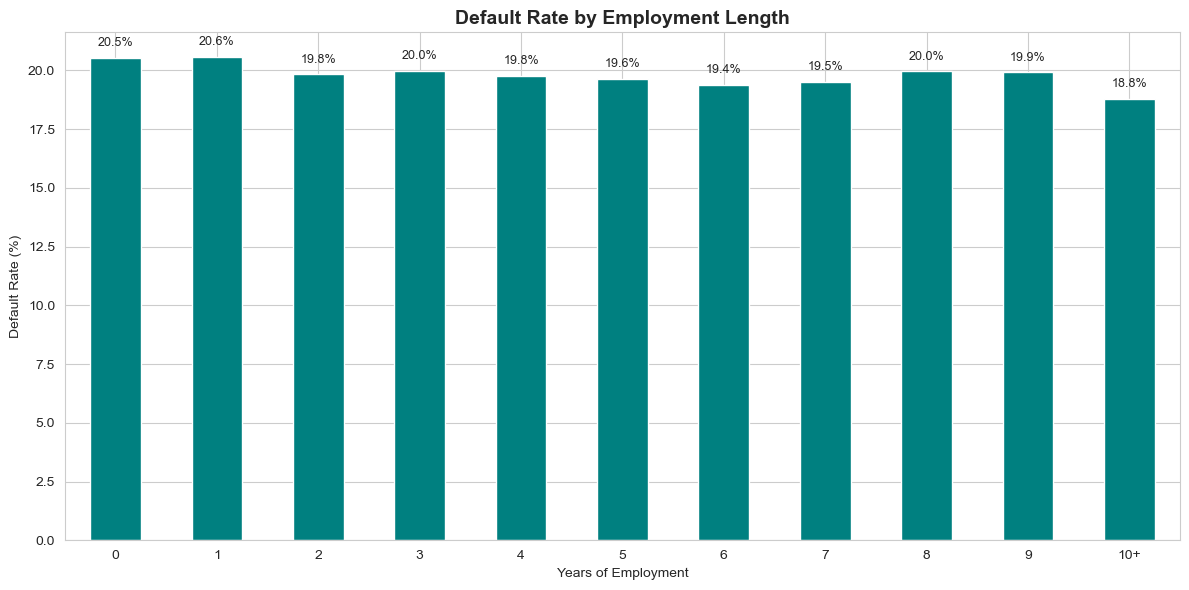

DEFAULT RATE BY EMPLOYMENT LENGTH
                  default_rate   count
emp_length_years                      
0.0                  20.542304  108537
1.0                  20.586878   88843
2.0                  19.823915  122100
3.0                  19.990173  107868
4.0                  19.759048   80763
5.0                  19.620283   84326
6.0                  19.378489   62879
7.0                  19.509745   59724
8.0                  19.955271   60811
9.0                  19.910230   51019
10.0                 18.799853  442679


In [22]:
# Employment length as stability indicator
emp_length_mapping = {
    '< 1 year': 0,
    '1 year': 1,
    '2 years': 2,
    '3 years': 3,
    '4 years': 4,
    '5 years': 5,
    '6 years': 6,
    '7 years': 7,
    '8 years': 8,
    '9 years': 9,
    '10+ years': 10
}

df['emp_length_years'] = df['emp_length'].map(emp_length_mapping)

# Calculate default rate by employment length
emp_default = df.groupby('emp_length_years')['is_default'].agg(['mean', 'count'])
emp_default.columns = ['default_rate', 'count']
emp_default['default_rate'] = emp_default['default_rate'] * 100
emp_default = emp_default.sort_index()

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
emp_default['default_rate'].plot(kind='bar', ax=ax, color='teal')
ax.set_title('Default Rate by Employment Length', fontsize=14, fontweight='bold')
ax.set_xlabel('Years of Employment')
ax.set_ylabel('Default Rate (%)')
ax.set_xticklabels([f'{int(x)}' if x < 10 else '10+' for x in emp_default.index], rotation=0)

for i, v in enumerate(emp_default['default_rate'].values):
    ax.text(i, v + 0.5, f'{v:.1f}%', ha='center', fontsize=9)

plt.tight_layout()
plt.savefig('../reports/employment_length_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("DEFAULT RATE BY EMPLOYMENT LENGTH")
print("="*60)
print(emp_default)

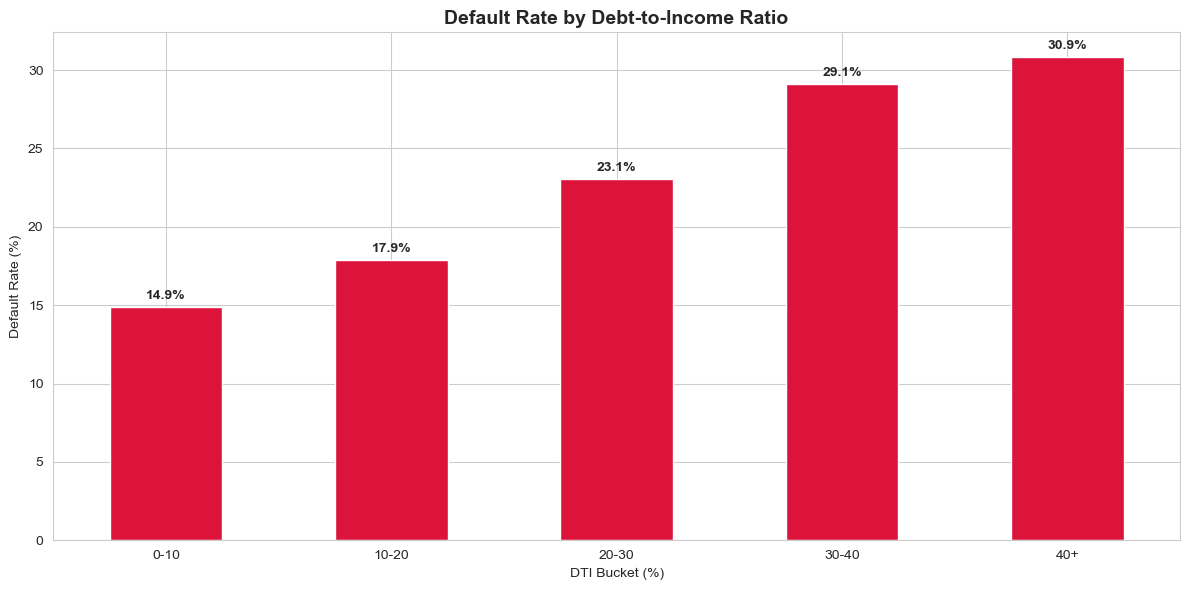

DEFAULT RATE BY DTI BUCKET
            default_rate   count
dti_bucket                      
0-10           14.903799  246152
10-20          17.871014  563348
20-30          23.056462  409035
30-40          29.102114  121541
40+            30.867961    6233

Critical Insight: DTI > 30% shows elevated default risk


In [24]:
# DTI is a critical credit metric
df['dti'] = pd.to_numeric(df['dti'], errors='coerce')

# Create DTI bins
df['dti_bucket'] = pd.cut(df['dti'], 
                           bins=[0, 10, 20, 30, 40, 100], 
                           labels=['0-10', '10-20', '20-30', '30-40', '40+'])

dti_default = df.groupby('dti_bucket')['is_default'].agg(['mean', 'count'])
dti_default.columns = ['default_rate', 'count']
dti_default['default_rate'] = dti_default['default_rate'] * 100

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
dti_default['default_rate'].plot(kind='bar', ax=ax, color='crimson')
ax.set_title('Default Rate by Debt-to-Income Ratio', fontsize=14, fontweight='bold')
ax.set_xlabel('DTI Bucket (%)')
ax.set_ylabel('Default Rate (%)')
ax.set_xticklabels(dti_default.index, rotation=0)

for i, v in enumerate(dti_default['default_rate'].values):
    ax.text(i, v + 0.5, f'{v:.1f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('../reports/dti_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("DEFAULT RATE BY DTI BUCKET")
print("="*60)
print(dti_default)
print("\nCritical Insight: DTI > 30% shows elevated default risk")

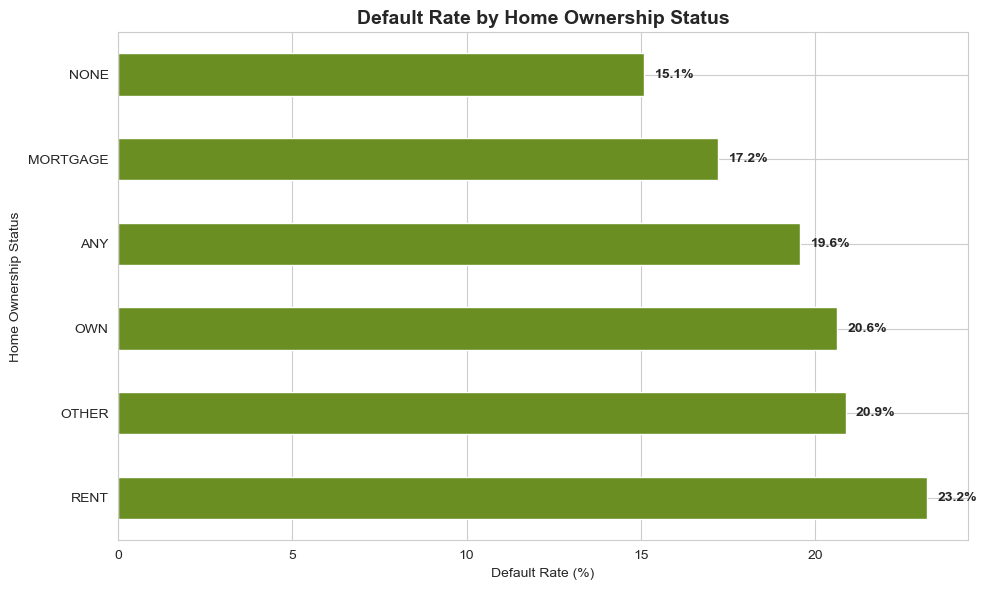

DEFAULT RATE BY HOME OWNERSHIP
                default_rate   count
home_ownership                      
RENT               23.229649  535699
OTHER              20.879121     182
OWN                20.631331  145027
ANY                19.580420     286
MORTGAGE           17.229610  666852
NONE               15.094340      53


In [26]:
# Home ownership as collateral/stability indicator
home_default = df.groupby('home_ownership')['is_default'].agg(['mean', 'count'])
home_default.columns = ['default_rate', 'count']
home_default['default_rate'] = home_default['default_rate'] * 100
home_default = home_default.sort_values('default_rate', ascending=False)

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
home_default['default_rate'].plot(kind='barh', ax=ax, color='olivedrab')
ax.set_title('Default Rate by Home Ownership Status', fontsize=14, fontweight='bold')
ax.set_xlabel('Default Rate (%)')
ax.set_ylabel('Home Ownership Status')

for i, v in enumerate(home_default['default_rate'].values):
    ax.text(v + 0.3, i, f'{v:.1f}%', va='center', fontweight='bold')

plt.tight_layout()
plt.savefig('../reports/home_ownership_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("DEFAULT RATE BY HOME OWNERSHIP")
print("="*60)
print(home_default)

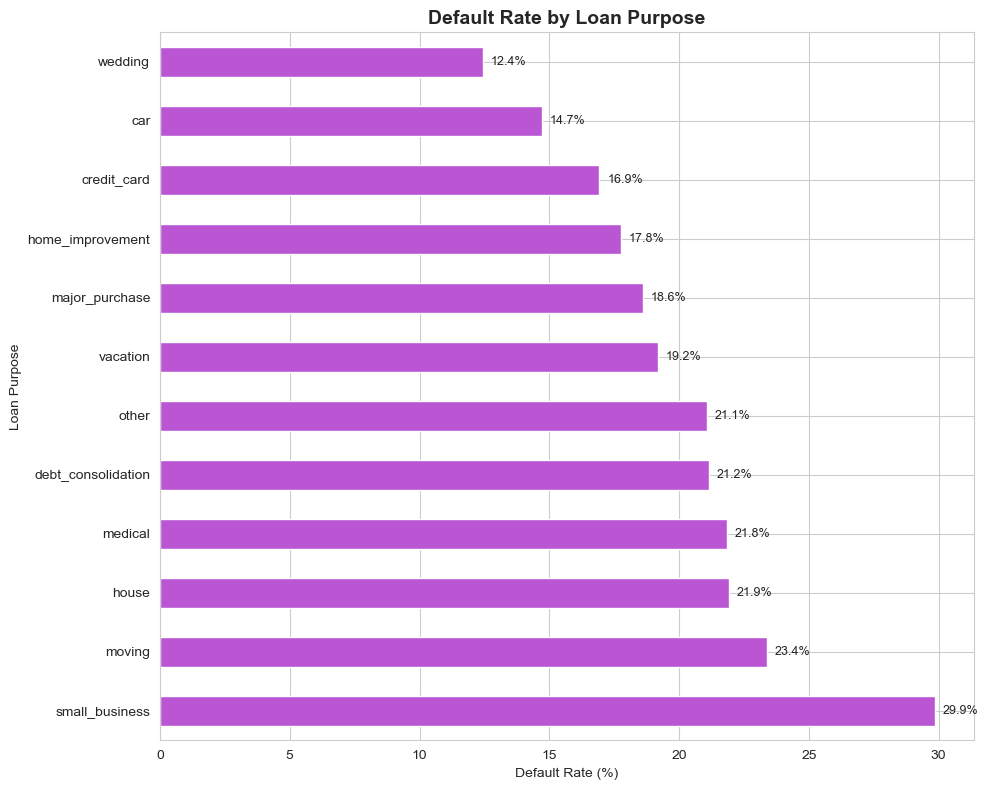

DEFAULT RATE BY LOAN PURPOSE
                    default_rate   count
purpose                                 
small_business         29.864544   15577
moving                 23.399118    9526
house                  21.910112    7298
medical                21.845779   15614
debt_consolidation     21.156657  781442
other                  21.082745   78301
vacation               19.198591    9084
major_purchase         18.605753   29550
home_improvement       17.756296   87721
credit_card            16.932600  295625
car                    14.721540   14652
wedding                12.425532    2350


In [28]:
# Understanding why borrowers need money
purpose_default = df.groupby('purpose')['is_default'].agg(['mean', 'count'])
purpose_default.columns = ['default_rate', 'count']
purpose_default['default_rate'] = purpose_default['default_rate'] * 100
purpose_default = purpose_default[purpose_default['count'] > 1000]  # Filter small categories
purpose_default = purpose_default.sort_values('default_rate', ascending=False)

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
purpose_default['default_rate'].plot(kind='barh', ax=ax, color='mediumorchid')
ax.set_title('Default Rate by Loan Purpose', fontsize=14, fontweight='bold')
ax.set_xlabel('Default Rate (%)')
ax.set_ylabel('Loan Purpose')

for i, v in enumerate(purpose_default['default_rate'].values):
    ax.text(v + 0.3, i, f'{v:.1f}%', va='center', fontsize=9)

plt.tight_layout()
plt.savefig('../reports/loan_purpose_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("DEFAULT RATE BY LOAN PURPOSE")
print("="*60)
print(purpose_default)